<a href="https://colab.research.google.com/github/adriendod/Self-Driving-Car/blob/master/Self_Driving_car_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip "/content/gdrive/My Drive/Data Science/Dataset udacity/training.zip" -d "/content/data/"

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
import cv2
import pandas as pd
import random
from PIL import Image
from google.colab import files
from tensorboardcolab import *

Using TensorFlow backend.


In [0]:
imagedir = "/content/data/training"
df = pd.read_csv("/content/data/training/drive_log.csv",header=None, names=["center", "left", "right", "steering", "acceleration", "breaking", "speed" ])
df.replace("/Users/adriendodinet/Downloads/beta_simulator_mac", "/content/data", regex=True, inplace=True)

In [0]:
imagedir = "/content/data/training"
df = pd.read_csv("/content/data/training/drive_log.csv")
df["File name"] = df["File name"].apply(lambda x: "/content/data/training/" + x.replace("capture ","") )

In [20]:
df.iloc[100:110]

,Index,File name,Driving direction
100,100,/content/data/training/100.jpg,0.000000
101,101,/content/data/training/101.jpg,0.000000
102,102,/content/data/training/102.jpg,0.000000
103,103,/content/data/training/103.jpg,0.000000
104,104,/content/data/training/104.jpg,0.000000
105,105,/content/data/training/105.jpg,-0.030945
106,106,/content/data/training/106.jpg,-0.041260
107,107,/content/data/training/107.jpg,-0.041260
108,108,/content/data/training/108.jpg,-0.134033
109,109,/content/data/training/109.jpg,-0.195892


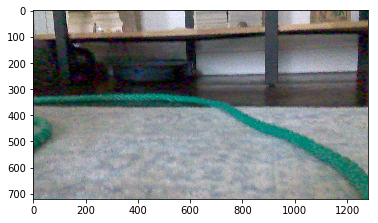

In [33]:
img = mpimg.imread(df["File name"][500])
plt.imshow(img)


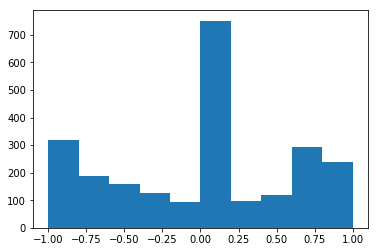

In [68]:
plt.hist(df['Driving direction'])
plt.show()

In [0]:
def load_img(imagedir, df):
  image_path = []
  steering = []
  for i in range(len(df)):
    indexed_data = df.iloc[i]
    image = indexed_data[1]
    image_path.append(os.path.join(imagedir, image.strip()))
    steering.append(indexed_data[2])
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings
  
image_paths, steerings = load_img(imagedir, df)
    

In [29]:
image = image_paths[100]
original_image = mpimg.imread(image)
original_image.shape

(720, 1280, 3)

In [30]:
steerings

array([0.        , 0.        , 0.        , ..., 0.98968506, 0.76287842,
       0.48452759])

In [0]:
def img_preprocess(img):
  img = mpimg.imread(img)
  img = img[400:720, :,: ]
  img = cv2.resize(img, (224,224))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  img = cv2.GaussianBlur(img, (3,3), 0)
  img = img/255
  return img

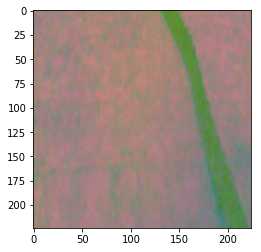

In [37]:
img = img_preprocess(image_paths[100])
plt.imshow(img)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, steerings,test_size = 0.2, random_state = 42)
print('Training Samples: {}\nTest Samples: {}'.format(len(X_train), len(X_test)))

Training Samples: 1902
Test Samples: 476


Text(0.5, 1.0, 'Preprocessed image')

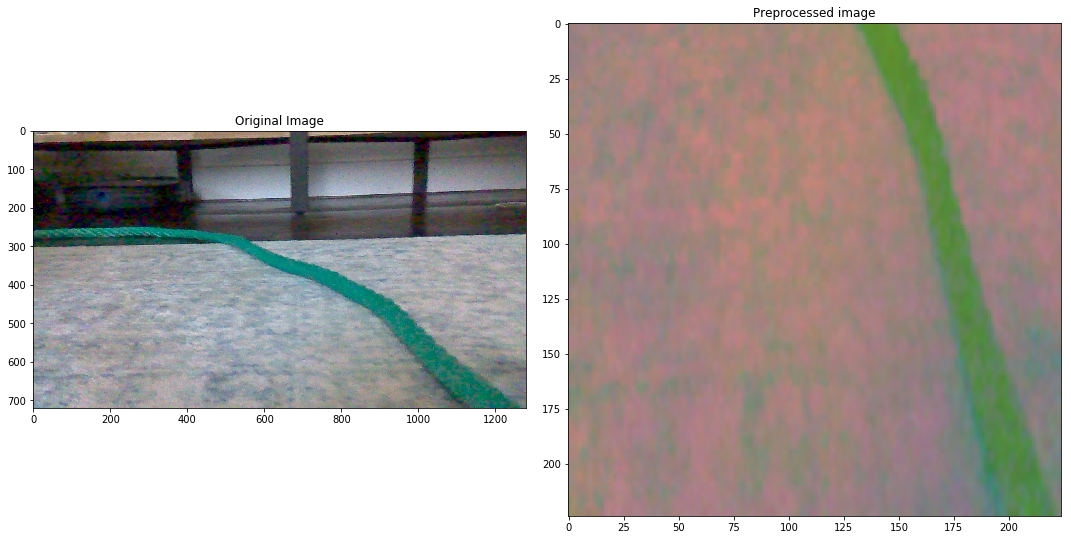

In [39]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(image)
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
fig.tight_layout()
ax[0].imshow(original_image)
ax[0].set_title("Original Image")
ax[1].imshow(preprocessed_image)
ax[1].set_title("Preprocessed image")

In [0]:
X_train = np.array(list(map(img_preprocess, X_train)))
X_test = np.array(list(map(img_preprocess, X_test)))

0.06182861328125
(1902, 224, 224, 3)


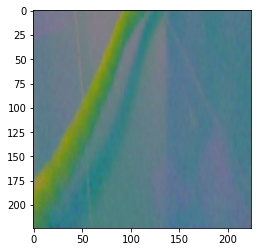

In [41]:
random_number = random.randint(0, len(X_train))
plt.imshow(X_train[random_number])
print (y_train[random_number])
print(X_train.shape)

In [0]:
def nvidia_model():
  model = Sequential()
  model.add(Convolution2D(24, 5, 5, subsample=(2,2), input_shape = (224, 224, 3), activation='relu'))
  model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu'))
  model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu'))
  model.add(Convolution2D(64, 3, 3, activation='relu'))
  model.add(Convolution2D(64, 3, 3, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Flatten())
  model.add(Dense(100, activation='relu'))
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='relu'))
  model.add(Dense(10, activation='relu'))
  model.add(Dense(1))
  
  optimizer = Adam(lr = 1e-4)
  model.compile(loss = 'mse', optimizer=optimizer)
  return model

In [46]:
#tbc=TensorBoardColab()
model = nvidia_model()
print(model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(224, 224,..., activation="relu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3),

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 110, 110, 24)      1824      
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 53, 53, 36)        21636     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 25, 25, 48)        43248     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 23, 23, 64)        27712     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 21, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28224)            

In [47]:
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), batch_size = 64, verbose = 1, shuffle = 1)


Train on 1902 samples, validate on 476 samples
Epoch 1/20
1902/1902 [==============================] - 13s 7ms/step - loss: 0.3373 - val_loss: 0.3490
Epoch 2/20
1902/1902 [==============================] - 5s 2ms/step - loss: 0.3332 - val_loss: 0.3394
Epoch 3/20
1902/1902 [==============================] - 5s 2ms/step - loss: 0.3213 - val_loss: 0.3091
Epoch 4/20
1902/1902 [==============================] - 5s 2ms/step - loss: 0.3030 - val_loss: 0.2790
Epoch 5/20
1902/1902 [==============================] - 5s 2ms/step - loss: 0.2675 - val_loss: 0.2466
Epoch 6/20
1902/1902 [==============================] - 5s 2ms/step - loss: 0.2451 - val_loss: 0.2147
Epoch 7/20
1902/1902 [==============================] - 5s 2ms/step - loss: 0.2346 - val_loss: 0.2013
Epoch 8/20
1902/1902 [==============================] - 5s 2ms/step - loss: 0.2201 - val_loss: 0.1970
Epoch 9/20
1902/1902 [==============================] - 5s 2ms/step - loss: 0.1955 - val_loss: 0.1743
Epoch 10/20
1902/1902 [==========

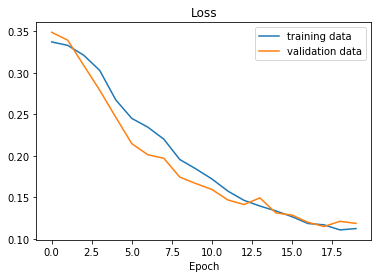

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training data', 'validation data'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()


In [0]:
model.save('/content/gdrive/My Drive/Data Science/Dataset udacity/voiture_model.h5')

In [0]:
"""""files.download('model.h5')"""""

(224, 224, 3)
Prediction:  [[-0.6260321]]
Actual:  -1.0


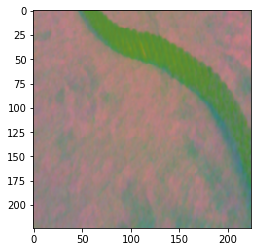

In [67]:
random_number = random.randint(0, len(X_test))
image = X_test[random_number]
print(image.shape)
image = image.reshape(1,224,224,3)
print("Prediction: ", model.predict(image))
print ("Actual: ", y_test[random_number])
plt.imshow(X_test[random_number])
